In [2]:
import os
import pandas as pd
import seaborn as sns
import pandasql as psql
import matplotlib.pyplot as plt
from cryptovision.tools import image_directory_to_pandas

2025-01-30 18:48:50.878 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [5]:
sources = {
    "sjb": '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226',
    "web": '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v250117/images',
    "inatlist": '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116',
    "lirs23": '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/LIRS23/Processed/Species/v250115/images',
    'cbc24': '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/CBC24/Processed/Species/v250115/images',
    'scls': '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SCLS/Processed/Species/v250115',
}

In [ ]:
df = pd.DataFrame()

for source, path in sources.items():
    df_source = image_directory_to_pandas(path, source=source)
    df = pd.concat([df, df_source], axis=0)
    

In [ ]:
total_sz = int(len(df))

query = f"""
SELECT
    source,
    COUNT(*) AS num_images,
    COUNT(DISTINCT family) AS num_families,
    COUNT(DISTINCT genus) AS num_genera,
    COUNT(DISTINCT species) AS num_species
FROM df
GROUP BY source
"""

psql.sqldf(query, locals())

,source,num_images,num_families,num_genera,num_species
0,cbc24,362,5,5,5
1,inatlist,17020,26,74,162
2,lirs23,877,19,54,122
3,scls,358,10,13,17
4,sjb,7672,19,51,101
5,web,6504,21,54,71


In [34]:
# New column 'std_image' with true if the image came from a given list of sources
df['std_image'] = df['source'].apply(lambda x: x in ['sjb', 'lirs23', 'cbc24', 'scls'])

,image_path,source,folder_label,family,genus,species,std_image
0,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
1,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
2,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
3,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True
4,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,True


In [55]:
print(f"Total number of images: {total_sz}")

for source in sources.keys():
    print(f"Number of images from {source}: {len(df[df['source'] == source])} ({len(df[df['source'] == source]) / total_sz * 100:.2f}%)")

Total number of images: 32793
Number of images from sjb: 7672 (23.40%)
Number of images from web: 6504 (19.83%)
Number of images from inatlist: 17020 (51.90%)
Number of images from lirs23: 877 (2.67%)
Number of images from cbc24: 362 (1.10%)
Number of images from scls: 358 (1.09%)


In [58]:
import plotly.express as px

# Count the number of samples per source
source_counts = df["source"].value_counts().reset_index()
source_counts.columns = ["source", "count"]

# Calculate the percentage for each source
source_counts["percentage"] = (source_counts["count"] / source_counts["count"].sum()) * 100

# Create a treemap with labels showing both source name and percentage
fig = px.treemap(
    source_counts,
    path=["source"],
    values="count",
    title="Dataset Composition by Source (Percentage)",
    color="count",
    color_continuous_scale="viridis",
    custom_data=["percentage"]  # Include percentage in custom data
)

# Update text labels to show both source name and percentage
fig.update_traces(
    textinfo="label+text",
    texttemplate="%{label}<br>%{customdata[0]:.f}%"
)

# Adjust layout size
fig.update_layout(
    width=800, height=600,
    margin=dict(t=50, l=25, r=25, b=25)
)

# Show the treemap
fig.show()

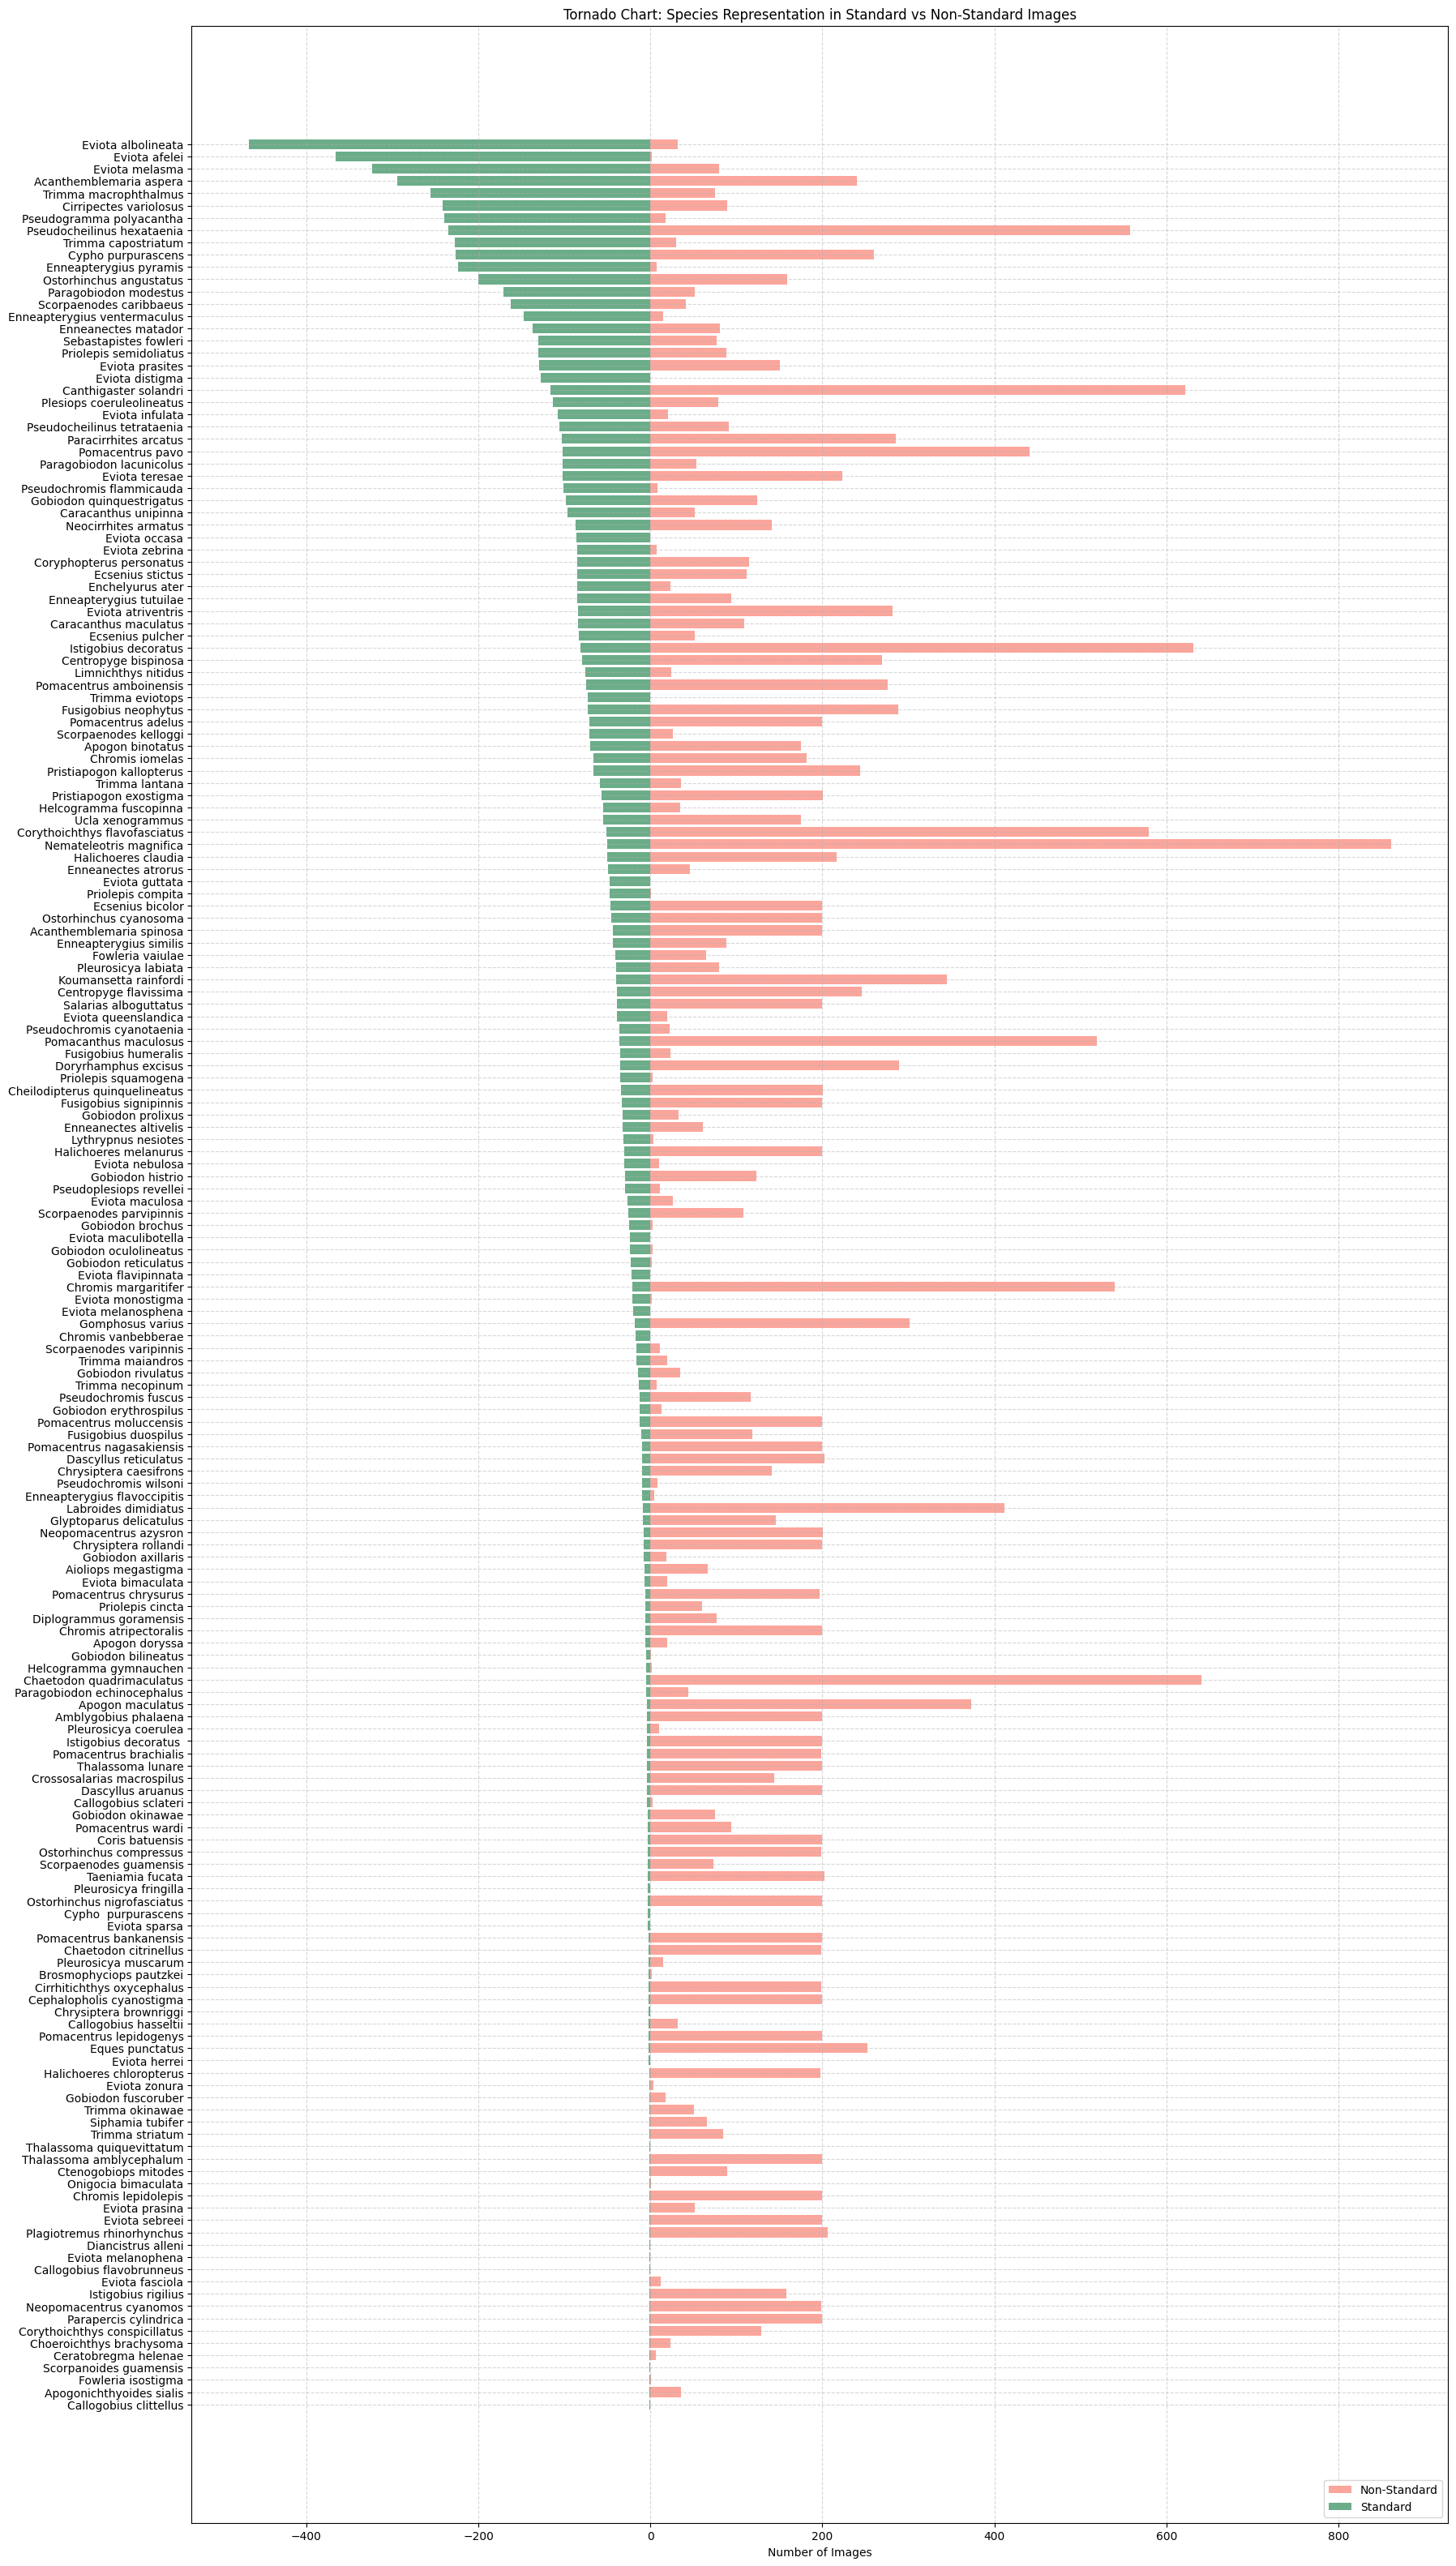

In [64]:
# Count number of images per species for std_image=True and std_image=False
std_counts = df[df["std_image"] == True]["species"].value_counts()
non_std_counts = df[df["std_image"] == False]["species"].value_counts()

# Merge into a single DataFrame to align both counts
tornado_df = pd.DataFrame({
    "Species": std_counts.index,
    "Standard": std_counts.values,
    "Non-Standard": non_std_counts.reindex(std_counts.index, fill_value=0).values  # Ensure alignment
}).sort_values(by="Standard", ascending=True)  # Sort for better visualization

# Create Tornado Chart
fig, ax = plt.subplots(figsize=(20, 40))

# Plot bars for Standard and Non-Standard images
ax.barh(tornado_df["Species"], tornado_df["Non-Standard"], color="salmon", label="Non-Standard", alpha=0.7)
ax.barh(tornado_df["Species"], -tornado_df["Standard"], color="seagreen", label="Standard", alpha=0.7)

# Formatting
ax.set_xlabel("Number of Images")
ax.set_title("Tornado Chart: Species Representation in Standard vs Non-Standard Images")
ax.legend(loc="lower right")
ax.grid(True, linestyle="--", alpha=0.5)

# Display the chart
plt.show()

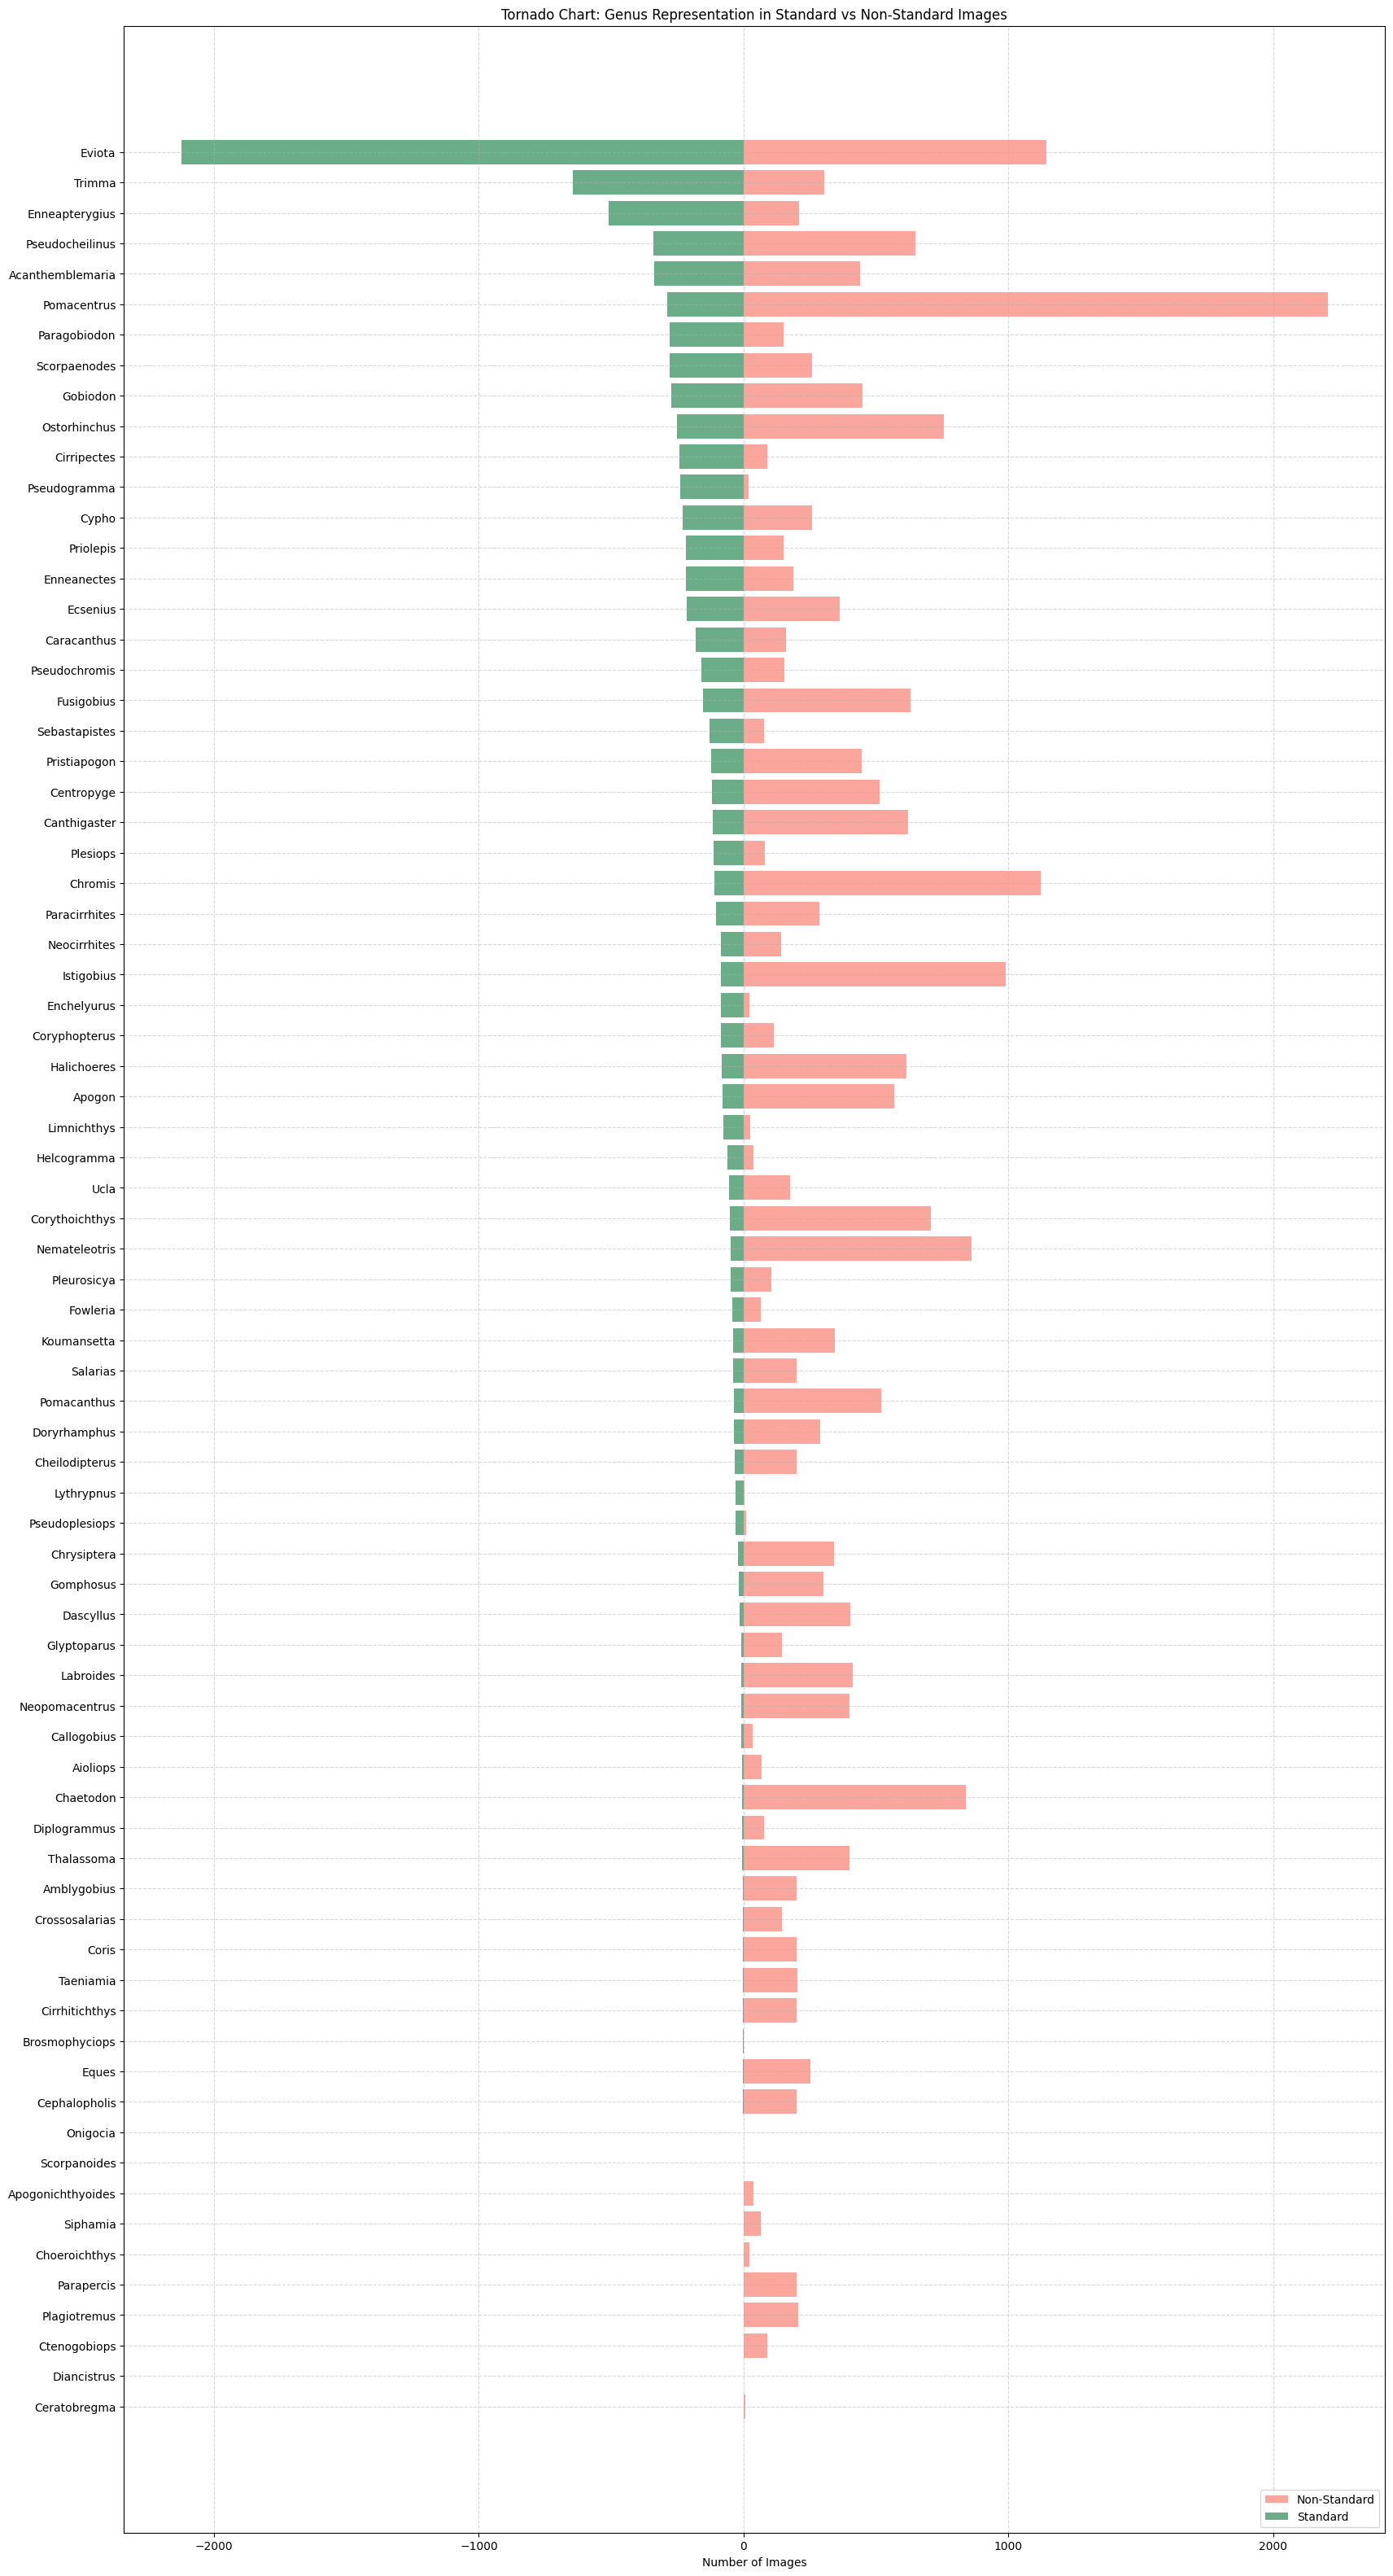

In [65]:
# Count number of images per species for std_image=True and std_image=False
std_counts = df[df["std_image"] == True]["genus"].value_counts()
non_std_counts = df[df["std_image"] == False]["genus"].value_counts()

# Merge into a single DataFrame to align both counts
tornado_df = pd.DataFrame({
    "Genus": std_counts.index,
    "Standard": std_counts.values,
    "Non-Standard": non_std_counts.reindex(std_counts.index, fill_value=0).values  # Ensure alignment
}).sort_values(by="Standard", ascending=True)  # Sort for better visualization

# Create Tornado Chart
fig, ax = plt.subplots(figsize=(20, 40))

# Plot bars for Standard and Non-Standard images
ax.barh(tornado_df["Genus"], tornado_df["Non-Standard"], color="salmon", label="Non-Standard", alpha=0.7)
ax.barh(tornado_df["Genus"], -tornado_df["Standard"], color="seagreen", label="Standard", alpha=0.7)

# Formatting
ax.set_xlabel("Number of Images")
ax.set_title("Tornado Chart: Genus Representation in Standard vs Non-Standard Images")
ax.legend(loc="lower right")
ax.grid(True, linestyle="--", alpha=0.5)

# Display the chart
plt.show()

In [9]:
# query to show the percentage of samples per source

query = f"""
SELECT
    source,
    COUNT(*) AS num_images,
    COUNT(DISTINCT family) AS num_families,
    COUNT(DISTINCT genus) AS num_genera,
    COUNT(DISTINCT species) AS num_species
FROM df
GROUP BY source
"""
psql.sqldf(query, locals())

,source,num_images,num_families,num_genera,num_species
0,cbc24,362,5,5,5
1,inatlist,17020,26,74,162
2,lirs23,877,19,54,122
3,scls,358,10,13,17
4,sjb,7672,19,51,101
5,web,6504,21,54,71


In [39]:
query = f"""
SELECT
    species,

    COUNT(*) AS num_images
FROM df
WHERE
    genus = 'Eviota'
GROUP BY species
HAVING num_images > 99
ORDER BY species
"""

psql.sqldf(query, locals())

,species,num_images
0,Eviota afelei,368
1,Eviota albolineata,499
2,Eviota atriventris,366
3,Eviota distigma,127
4,Eviota infulata,129
5,Eviota melasma,403
6,Eviota prasites,280
7,Eviota sebreei,201
8,Eviota teresae,325


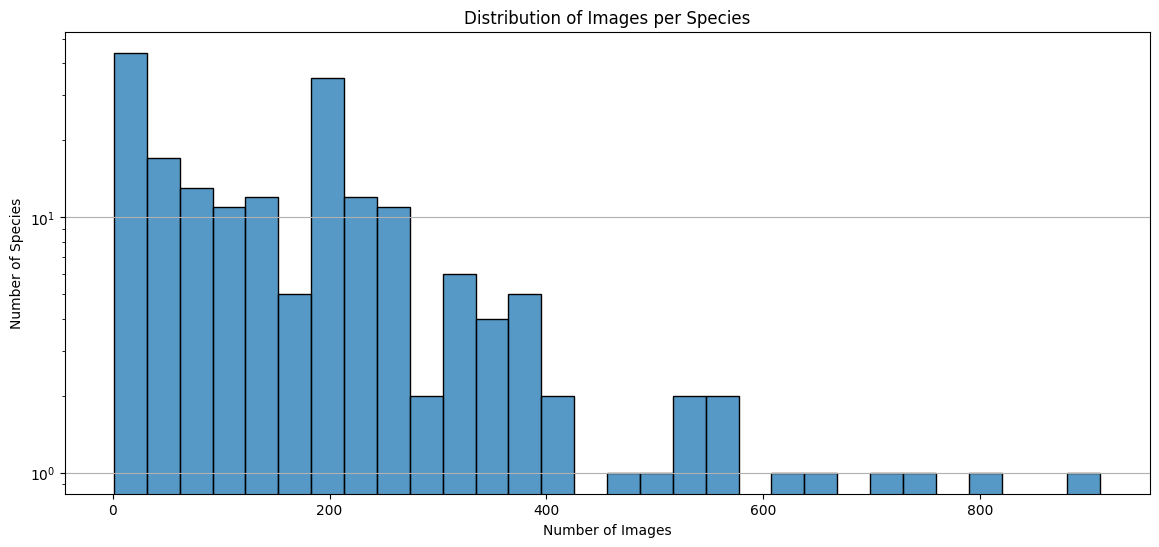

In [29]:
# Group by species and count the number of images per species
species_counts = df['species'].value_counts()

# Plot the distribution of images per species
plt.figure(figsize=(14, 6))
sns.histplot(species_counts, bins=30, kde=False)
plt.title("Distribution of Images per Species")
plt.xlabel("Number of Images")
plt.ylabel("Number of Species")
plt.yscale('log')  # Use a logarithmic scale if there are significant outliers
plt.grid(axis='y')
plt.show()

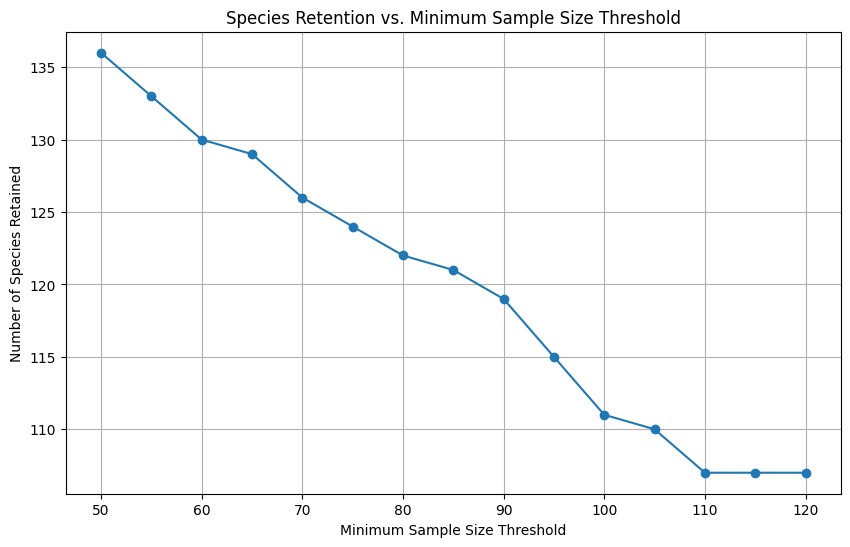

In [35]:
import numpy as np

# Function to calculate species retention based on different thresholds
def calculate_retention(thresholds, species_counts):
    retention = []
    for t in thresholds:
        retained_species = (species_counts >= t).sum()
        retention.append(retained_species)
    return retention

# Define a range of thresholds to test
thresholds = np.array(range(50, 125, 5))
retention = calculate_retention(thresholds, species_counts)

# Plot retention vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, retention, marker='o')
plt.title("Species Retention vs. Minimum Sample Size Threshold")
plt.xlabel("Minimum Sample Size Threshold")
plt.ylabel("Number of Species Retained")
plt.grid()
plt.show()


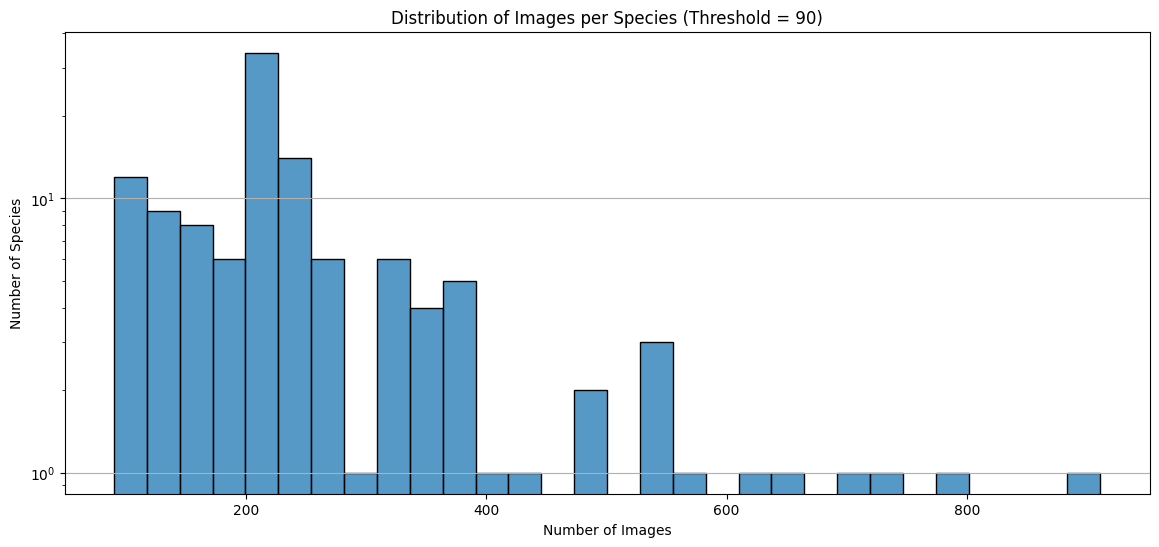

Number of species retained with at least 90 images: 119


In [34]:
# Select a threshold (e.g., 20 images)
threshold = 90

# Filter out species with fewer images than the threshold
filtered_species_counts = species_counts[species_counts >= threshold]

# Plot the distribution after filtering
plt.figure(figsize=(14, 6))
sns.histplot(filtered_species_counts, bins=30, kde=False)
plt.title(f"Distribution of Images per Species (Threshold = {threshold})")
plt.xlabel("Number of Images")
plt.ylabel("Number of Species")
plt.yscale('log')
plt.grid(axis='y')
plt.show()

# Display how many species are retained
print(f"Number of species retained with at least {threshold} images: {len(filtered_species_counts)}")


In [69]:
# create dataset with species with over 99 samples
counts = df['species'].value_counts()
df_filterad = df[df['species'].isin(counts[counts >= 100].index)]
df_filterad.shape

(29879, 7)

In [26]:
# Create a stratified sample (20% of each category)
stratified_sample = df_filterad.groupby('species').apply(lambda x: x.sample(frac=0.1))

# Reset the index
stratified_sample.reset_index(drop=True, inplace=True)

print(stratified_sample.shape)
stratified_sample.head(10)

(2985, 6)


/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_20185/148426330.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df_filterad.groupby('species').apply(lambda x: x.sample(frac=0.1))


,image_path,source,folder_label,family,genus,species
0,/Volumes/T7_shield/CryptoVision/Data/Images/So...,cbc24,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
1,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
2,/Volumes/T7_shield/CryptoVision/Data/Images/So...,cbc24,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
3,/Volumes/T7_shield/CryptoVision/Data/Images/So...,cbc24,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
4,/Volumes/T7_shield/CryptoVision/Data/Images/So...,inatlist,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
5,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
6,/Volumes/T7_shield/CryptoVision/Data/Images/So...,cbc24,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
7,/Volumes/T7_shield/CryptoVision/Data/Images/So...,sjb,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
8,/Volumes/T7_shield/CryptoVision/Data/Images/So...,inatlist,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera
9,/Volumes/T7_shield/CryptoVision/Data/Images/So...,cbc24,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera


In [27]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import os
from tqdm import tqdm


# Load a pretrained model without the classification head (feature extractor)
base_model = ResNet152V2(weights="imagenet", include_top=False, pooling="avg")

# Function to extract image features
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalize for the model
    features = model.predict(img_array, verbose=0)
    return features.flatten()  # Flatten to 1D feature vector

feat = []

for index, row in tqdm(stratified_sample.iterrows(), total=len(stratified_sample), desc="Extracting features"):
    img_path = row['image_path']
    features = extract_features(img_path, base_model)
    feat.append(features)

Extracting features: 100%|██████████| 2985/2985 [05:16<00:00,  9.42it/s]


In [29]:
stratified_sample['features'] = feat

stratified_sample.head()

,image_path,source,folder_label,family,genus,species,features
0,/Volumes/T7_shield/CryptoVision/Data/Images/So...,cbc24,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera,"[0.003649, 6.92, 0.0, 0.0, 0.2255, 0.273, 0.03..."
1,/Volumes/T7_shield/CryptoVision/Data/Images/So...,web,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera,"[0.0, 2.012, 0.03995, 0.2142, 0.0939, 1.138, 0..."
2,/Volumes/T7_shield/CryptoVision/Data/Images/So...,cbc24,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera,"[0.0968, 1.376, 0.0, 0.06573, 0.1761, 0.5303, ..."
3,/Volumes/T7_shield/CryptoVision/Data/Images/So...,cbc24,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera,"[0.1678, 7.6, 0.4106, 0.0, 0.0, 1.688, 0.147, ..."
4,/Volumes/T7_shield/CryptoVision/Data/Images/So...,inatlist,Chaenopsidae_Acanthemblemaria_aspera,Chaenopsidae,Acanthemblemaria,Acanthemblemaria aspera,"[0.0, 0.00452, 0.0, 0.0, 0.0, 0.12024, 0.2079,..."


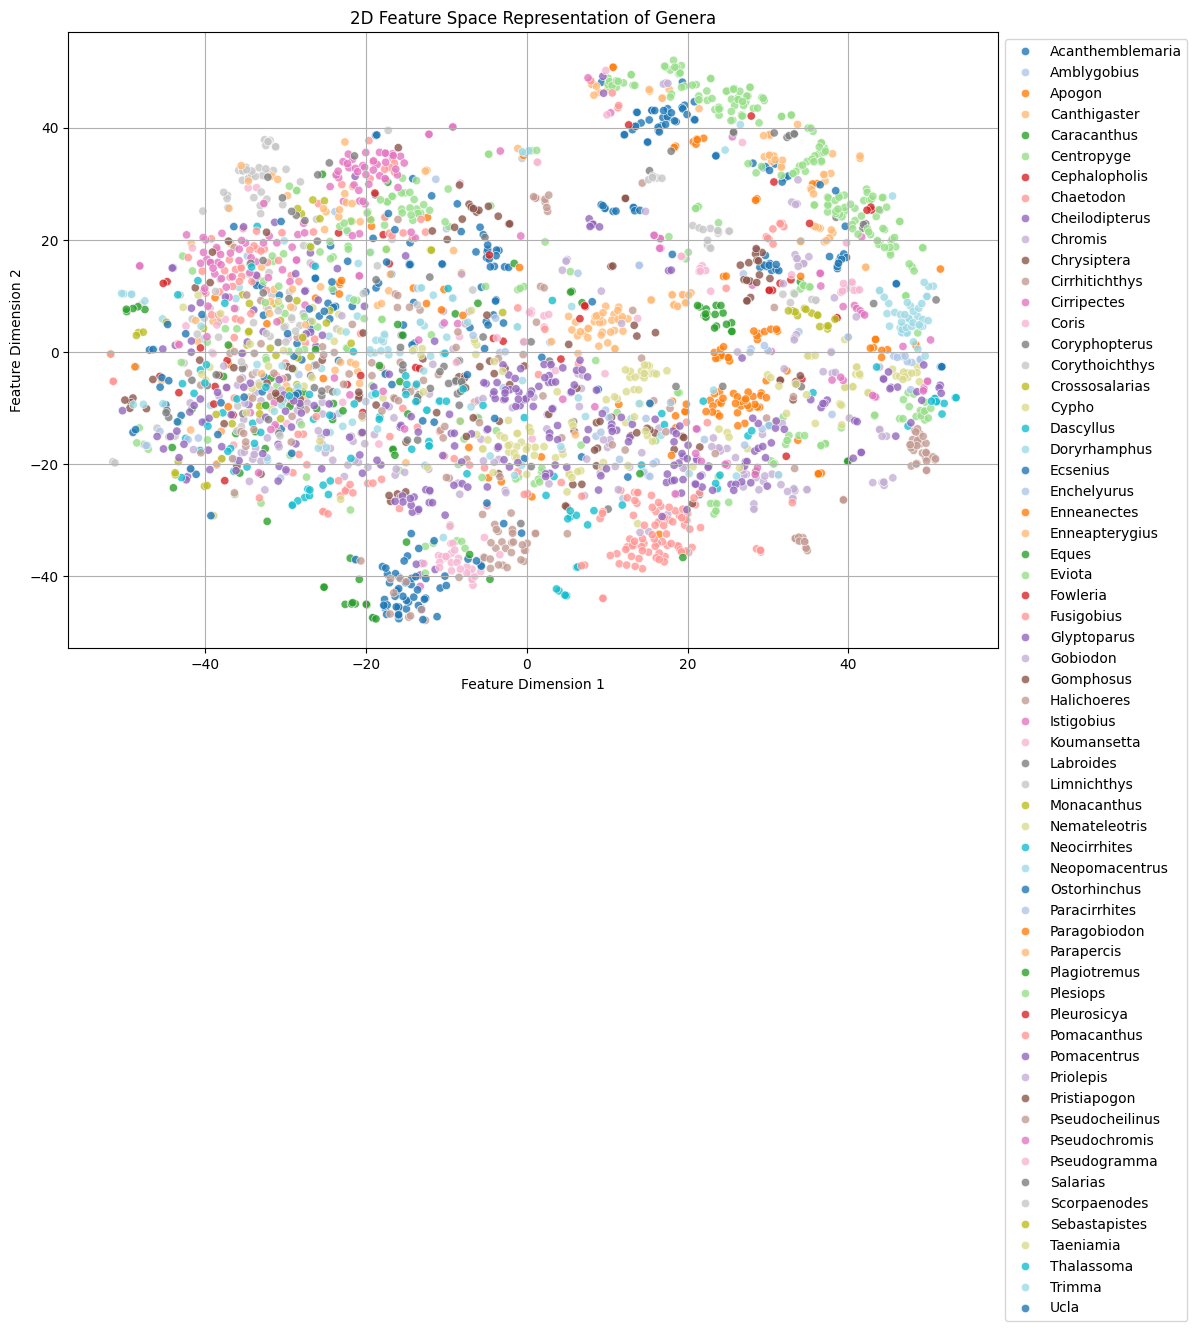

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import umap

# Convert extracted features into a NumPy array
feature_matrix = np.vstack(stratified_sample["features"].values)

# Choose a dimensionality reduction method
method = "tsne"  # Options: "pca", "tsne", "umap"

if method == "pca":
    reducer = PCA(n_components=2)
elif method == "tsne":
    reducer = TSNE(n_components=2, perplexity=30, random_state=42)
elif method == "umap":
    pass
    # reducer = umap.UMAP(n_components=2, random_state=42)

# Apply dimensionality reduction
embedding_2D = reducer.fit_transform(feature_matrix)

# Store results in the DataFrame
stratified_sample["x"] = embedding_2D[:, 0]
stratified_sample["y"] = embedding_2D[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(x=stratified_sample["x"], y=stratified_sample["y"], hue=stratified_sample["genus"], palette="tab20", alpha=0.8)
plt.xlabel("Feature Dimension 1")
plt.ylabel("Feature Dimension 2")
plt.title("2D Feature Space Representation of Genera")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()


In [3]:
import pandas as pd
from cryptovision.tools import image_directory_to_pandas

# compare build v1 dataset vs strucutred v1 dataset

# Load the structured dataset
df_struct = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v1.0.0/images'
)

df_v1 = pd.concat(
    [
        image_directory_to_pandas(
            '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v240802/images'),
        image_directory_to_pandas(
            '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Web/Species/v240712/images'),
    ],
    axis=0
)

# Display the number of images in each dataset
print(f"Number of images in the structured dataset: {len(df_struct)}")
print(f"Number of images in the original dataset: {len(df_v1)}")

2025-01-31 11:44:37.063 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


Number of images in the structured dataset: 9016
Number of images in the original dataset: 10969


In [5]:
df_v1 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v1.0.0/images'
)

df_lab = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226/images', 'lab'
)

df_inat = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images', 'inat'
)

In [6]:
import os

def get_prefix(path):
    filename = os.path.basename(path)
    return filename[:3]


df_v1['source'] = df_v1['image_path'].apply(get_prefix)

df_v1.head(5)

,image_path,folder_label,family,genus,species,source
0,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
1,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
2,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,sjb
3,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
4,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web


In [8]:
import pandas as pd

df_new = pd.concat(
    [
        df_v1,
        df_lab,
        df_inat
    ],
    axis=0,
    ignore_index=True
    
)

df_new.head(5)

,image_path,folder_label,family,genus,species,source
0,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
1,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
2,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,sjb
3,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
4,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web


In [15]:
sp_list = ['Eviota albolineata', 'Nemateleotris magnifica', 'Acanthemblemaria aspera']

df_new_all = df_new[df_new['species'].isin(sp_list)]

df_v1 = df_v1[~df_v1['species'].isin(sp_list)]

df_new_all['source'].unique()

array(['sjb', 'web', 'lab', 'inat'], dtype=object)

In [21]:
import pandasql as psql

df_final = pd.concat(
    [
        df_v1,
        df_new_all[df_new_all['source'].isin(['sjb', 'web', 'lab'])],
    ]
)

query = """
SELECT
    species,
    source,
    COUNT(*) AS images
FROM df_final
WHERE species IN ('Eviota albolineata', 'Nemateleotris magnifica', 'Acanthemblemaria aspera')
GROUP BY species, source
"""

psql.sqldf(query, locals())

,species,source,images
0,Acanthemblemaria aspera,lab,73
1,Acanthemblemaria aspera,sjb,50
2,Acanthemblemaria aspera,web,36
3,Eviota albolineata,lab,467
4,Eviota albolineata,sjb,70
5,Eviota albolineata,web,22
6,Nemateleotris magnifica,lab,50
7,Nemateleotris magnifica,sjb,9
8,Nemateleotris magnifica,web,657


In [17]:
import pandasql as psql

query = """
SELECT
    species,
    source,
    COUNT(*) AS images
FROM df_v1
WHERE genus = 'Eviota'
GROUP BY species, source
"""

psql.sqldf(query, locals())

,species,source,images
0,Eviota albolineata,sjb,70
1,Eviota albolineata,web,22
2,Eviota atriventris,sjb,3
3,Eviota atriventris,web,131
4,Eviota melasma,sjb,47
5,Eviota melasma,web,50


In [49]:
import os
import pandas as pd
import pandasql as psql
from cryptovision.tools import image_directory_to_pandas


# 1. Load Dataset
# Version 1
df_v1 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v1.0.0/images'
)

# With LAB images
df_lab = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226/images', 'lab'
)

# With InaturaList images
df_inat = image_directory_to_pandas(
    #'/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250116/images', 'inat'
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images', 'inat'
)

# 2. Create source column for V1 dataset
def get_prefix(path):
    filename = os.path.basename(path)
    return filename[:3]

df_v1['source'] = df_v1['image_path'].apply(get_prefix)

# 3. Concatenate datasets
df_new = pd.concat(
    [
        df_v1,
        df_lab,
        df_inat,
    ],
    axis=0,
    ignore_index=True
)

# 4. Filtrate image from sources lab and inat that is not Eviota albolineata, Nemateleotris magnifica, Acanthemblemaria aspera
sp_list = ['Eviota albolineata', 'Nemateleotris magnifica', 'Acanthemblemaria aspera']

df_sp = df_new[df_new['species'].isin(sp_list)]

df_new = df_new[~df_new['species'].isin(sp_list) & ~df_new['source'].isin(['lab', 'inat'])]

# 5. Final dataset
df_final_inat = pd.concat(
    [
        df_new,
        df_sp[df_sp['source'].isin(['inat', 'web', 'sjb'])],
    ],
    axis=0,
    ignore_index=True
)

print(df_final_inat['source'].unique())

df_final_lab = pd.concat(
    [
        df_new,
        df_sp[df_sp['source'].isin(['lab', 'web', 'sjb'])],
    ],
    axis=0,
    ignore_index=True
)

print(df_final_lab['source'].unique())

df_final_all = pd.concat(
    [
        df_new,
        df_sp[df_sp['source'].isin(['lab', 'web', 'sjb', 'inat'])],
    ],
    axis=0,
    ignore_index=True
)

print(df_final_all['source'].unique())

['web' 'sjb' 'inat']
['web' 'sjb' 'lab']
['web' 'sjb' 'lab' 'inat']


In [50]:
query = """
SELECT
    species,
    source,
    COUNT(*) AS images
FROM df_final_all
WHERE species IN ('Eviota albolineata', 'Nemateleotris magnifica', 'Acanthemblemaria aspera')
GROUP BY species, source
"""

psql.sqldf(query, locals())

,species,source,images
0,Acanthemblemaria aspera,inat,190
1,Acanthemblemaria aspera,lab,73
2,Acanthemblemaria aspera,sjb,50
3,Acanthemblemaria aspera,web,36
4,Eviota albolineata,lab,467
5,Eviota albolineata,sjb,70
6,Eviota albolineata,web,22
7,Nemateleotris magnifica,lab,50
8,Nemateleotris magnifica,sjb,9
9,Nemateleotris magnifica,web,657


In [28]:
# Plotly Horizontal Bar Chart
import plotly.express as px

df_chart = psql.sqldf(
    """
    SELECT
        species,
        source,
        COUNT(*) AS images
    FROM df_final_all
    GROUP BY species, source
    """
    , locals()
)

fig = px.bar(df_chart, x='images', y='species', color='source', barmode='stack', orientation='h')

fig.update_layout(
    width=800, height=1000,
    #margin=dict(t=50, l=25, r=25, b=25)
)

fig.show()

In [21]:
from cryptovision.tools import tf_dataset_from_pandas, split_image_dataframe

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_per_class_metrics(test_ds, model, family_labels, genus_labels, species_labels):
    """
    Evaluate accuracy, precision, recall, and support for each class across Family, Genus, and Species predictions.

    Parameters:
        test_ds (tf.data.Dataset): Test dataset
        model (tf.keras.Model): Trained model
        family_labels, genus_labels, species_labels (list): Unique labels for Family, Genus, and Species

    Returns:
        metrics_summary (dict): Dictionary containing metrics for Family, Genus, and Species
    """
    all_true_families = []
    all_pred_families = []
    all_true_genus = []
    all_pred_genus = []
    all_true_species = []
    all_pred_species = []

    # Collect all predictions and true labels
    for batch in test_ds:
        images, labels = batch
        family_true = tf.argmax(labels['family'], axis=1).numpy()
        genus_true = tf.argmax(labels['genus'], axis=1).numpy()
        species_true = tf.argmax(labels['species'], axis=1).numpy()

        preds = model.predict(images, verbose=0)
        family_pred = tf.argmax(preds[0], axis=1).numpy()
        genus_pred = tf.argmax(preds[1], axis=1).numpy()
        species_pred = tf.argmax(preds[2], axis=1).numpy()

        all_true_families.extend(family_true)
        all_pred_families.extend(family_pred)
        all_true_genus.extend(genus_true)
        all_pred_genus.extend(genus_pred)
        all_true_species.extend(species_true)
        all_pred_species.extend(species_pred)

    # Helper function to calculate metrics per class
    def calculate_metrics_per_class(y_true, y_pred, labels):
        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=range(len(labels)))
        accuracy = accuracy_score(y_true, y_pred)
        metrics = pd.DataFrame({
            'Class': labels,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        }).set_index('Class')
        return metrics, accuracy

    # Calculate metrics for each output
    family_metrics, family_accuracy = calculate_metrics_per_class(all_true_families, all_pred_families, family_labels)
    genus_metrics, genus_accuracy = calculate_metrics_per_class(all_true_genus, all_pred_genus, genus_labels)
    species_metrics, species_accuracy = calculate_metrics_per_class(all_true_species, all_pred_species, species_labels)

    # Display and summarize results
    print("\nFamily-Level Metrics")
    print(f"Accuracy: {family_accuracy:.4f}")
    display(family_metrics)

    print("\nGenus-Level Metrics")
    print(f"Accuracy: {genus_accuracy:.4f}")
    display(genus_metrics)

    print("\nSpecies-Level Metrics")
    print(f"Accuracy: {species_accuracy:.4f}")
    display(species_metrics)

    # Summarize results in a dictionary
    metrics_summary = {
        'Family': {'metrics': family_metrics, 'accuracy': family_accuracy},
        'Genus': {'metrics': genus_metrics, 'accuracy': genus_accuracy},
        'Species': {'metrics': species_metrics, 'accuracy': species_accuracy}
    }

    return metrics_summary

SEED = 42

def create_test_ds(df):

    train_df, val_df, test_df = split_image_dataframe(
            df, 
            test_size=0.15, 
            val_size=0.15, 
            stratify_by='folder_label',
            random_state=SEED
        )

    test_ds, _, _, _ = tf_dataset_from_pandas(
            test_df, 
            batch_size=128, 
            image_size=(128, 128),
        )
    
    return test_ds

test_ds_v1 = create_test_ds(df_v1)
test_ds_lab = create_test_ds(df_final_lab)
test_ds_inat = create_test_ds(df_final_inat)

In [29]:
import tensorflow as tf

names = {
    'family': sorted(df_final['family'].unique()),
    'genus': sorted(df_final['genus'].unique()),
    'species': sorted(df_final['species'].unique()),
}

model_v1 = tf.keras.models.load_model('/Users/leonardo/Documents/Projects/cryptovision/models/BasicModel128DS100/model_trained.keras')
model_lab = tf.keras.models.load_model('/Users/leonardo/Documents/Projects/cryptovision/models/BasicModel128DS100_StdPlus/model_trained.keras')
model_inat = tf.keras.models.load_model('/Users/leonardo/Documents/Projects/cryptovision/models/BasicModel128DS100_INatPlus/model_trained.keras')
model_all = tf.keras.models.load_model('/Users/leonardo/Documents/Projects/cryptovision/models/BasicModel128DS100_AllPlus/model_trained.keras')


/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 26 variables. 



###'Eviota albolineata', 'Nemateleotris magnifica', 'Acanthemblemaria aspera'

In [22]:
evaluate_per_class_metrics(test_ds_v1, model_v1, names['family'], names['genus'], names['species'])


Family-Level Metrics
Accuracy: 0.7775


2025-01-31 14:26:40.543390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Precision,Recall,F1-Score,Support
Class,,,,
Apogonidae,0.923810,0.881818,0.902326,110
Blenniidae,0.675000,0.529412,0.593407,51
Chaenopsidae,0.600000,0.230769,0.333333,13
Chaetodontidae,0.911111,0.773585,0.836735,53
Cirrhitidae,0.866667,0.722222,0.787879,36
Creediidae,1.000000,0.375000,0.545455,8
Gobiidae,0.753986,0.848718,0.798552,390
Labridae,0.798611,0.804196,0.801394,143
Plesiopidae,0.733333,0.785714,0.758621,14



Genus-Level Metrics
Accuracy: 0.7051


,Precision,Recall,F1-Score,Support
Class,,,,
Acanthemblemaria,0.500000,0.307692,0.380952,13
Aioliops,0.846154,0.916667,0.880000,12
Apogon,0.928571,0.886364,0.906977,44
Canthigaster,0.606742,0.720000,0.658537,75
Caracanthus,0.710526,0.900000,0.794118,30
Centropyge,0.857143,0.888889,0.872727,27
Chaetodon,0.933333,0.792453,0.857143,53
Chromis,0.696429,0.672414,0.684211,58
Cirripectes,0.588235,0.625000,0.606061,16



Species-Level Metrics
Accuracy: 0.7021


,Precision,Recall,F1-Score,Support
Class,,,,
Acanthemblemaria aspera,0.500000,0.307692,0.380952,13
Aioliops megastigma,0.750000,1.000000,0.857143,12
Apogon binotatus,0.882353,0.789474,0.833333,19
Apogon maculatus,0.740741,0.800000,0.769231,25
Canthigaster solandri,0.604396,0.733333,0.662651,75
Caracanthus maculatus,0.720000,0.900000,0.800000,20
Caracanthus unipinna,0.875000,0.700000,0.777778,10
Centropyge bispinosa,0.750000,1.000000,0.857143,18
Centropyge flavissima,0.888889,0.888889,0.888889,9


{'Family': {'metrics':                  Precision    Recall  F1-Score  Support
  Class                                                  
  Apogonidae        0.923810  0.881818  0.902326      110
  Blenniidae        0.675000  0.529412  0.593407       51
  Chaenopsidae      0.600000  0.230769  0.333333       13
  Chaetodontidae    0.911111  0.773585  0.836735       53
  Cirrhitidae       0.866667  0.722222  0.787879       36
  Creediidae        1.000000  0.375000  0.545455        8
  Gobiidae          0.753986  0.848718  0.798552      390
  Labridae          0.798611  0.804196  0.801394      143
  Plesiopidae       0.733333  0.785714  0.758621       14
  Pomacanthidae     0.873563  0.883721  0.878613       86
  Pomacentridae     0.758621  0.792793  0.775330      111
  Pseudochromidae   0.586207  0.680000  0.629630       25
  Sciaenidae        1.000000  0.625000  0.769231        8
  Scorpaenidae      0.830189  0.830189  0.830189       53
  Serranidae        1.000000  0.647059  0.785714   

In [23]:
evaluate_per_class_metrics(test_ds_lab, model_lab, names['family'], names['genus'], names['species'])


Family-Level Metrics
Accuracy: 0.7842


2025-01-31 14:26:52.484274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Precision,Recall,F1-Score,Support
Class,,,,
Apogonidae,0.830508,0.890909,0.859649,110
Blenniidae,0.700000,0.549020,0.615385,51
Chaenopsidae,0.800000,0.666667,0.727273,24
Chaetodontidae,0.959184,0.886792,0.921569,53
Cirrhitidae,0.857143,0.666667,0.750000,36
Creediidae,0.666667,0.250000,0.363636,8
Gobiidae,0.801653,0.830835,0.815983,467
Labridae,0.704403,0.783217,0.741722,143
Plesiopidae,0.909091,0.714286,0.800000,14



Genus-Level Metrics
Accuracy: 0.7509


,Precision,Recall,F1-Score,Support
Class,,,,
Acanthemblemaria,0.727273,0.666667,0.695652,24
Aioliops,0.857143,1.000000,0.923077,12
Apogon,0.872340,0.931818,0.901099,44
Canthigaster,0.580000,0.773333,0.662857,75
Caracanthus,0.833333,0.833333,0.833333,30
Centropyge,0.862069,0.925926,0.892857,27
Chaetodon,0.923077,0.905660,0.914286,53
Chromis,0.788462,0.706897,0.745455,58
Cirripectes,1.000000,0.687500,0.814815,16



Species-Level Metrics
Accuracy: 0.7564


,Precision,Recall,F1-Score,Support
Class,,,,
Acanthemblemaria aspera,0.833333,0.625000,0.714286,24
Aioliops megastigma,0.846154,0.916667,0.880000,12
Apogon binotatus,0.772727,0.894737,0.829268,19
Apogon maculatus,0.760000,0.760000,0.760000,25
Canthigaster solandri,0.685393,0.813333,0.743902,75
Caracanthus maculatus,0.782609,0.900000,0.837209,20
Caracanthus unipinna,0.777778,0.700000,0.736842,10
Centropyge bispinosa,0.857143,1.000000,0.923077,18
Centropyge flavissima,0.533333,0.888889,0.666667,9


{'Family': {'metrics':                  Precision    Recall  F1-Score  Support
  Class                                                  
  Apogonidae        0.830508  0.890909  0.859649      110
  Blenniidae        0.700000  0.549020  0.615385       51
  Chaenopsidae      0.800000  0.666667  0.727273       24
  Chaetodontidae    0.959184  0.886792  0.921569       53
  Cirrhitidae       0.857143  0.666667  0.750000       36
  Creediidae        0.666667  0.250000  0.363636        8
  Gobiidae          0.801653  0.830835  0.815983      467
  Labridae          0.704403  0.783217  0.741722      143
  Plesiopidae       0.909091  0.714286  0.800000       14
  Pomacanthidae     0.754717  0.930233  0.833333       86
  Pomacentridae     0.809524  0.765766  0.787037      111
  Pseudochromidae   0.863636  0.760000  0.808511       25
  Sciaenidae        1.000000  0.625000  0.769231        8
  Scorpaenidae      0.928571  0.735849  0.821053       53
  Serranidae        1.000000  1.000000  1.000000   

In [26]:
evaluate_per_class_metrics(test_ds_inat, model_inat, names['family'], names['genus'], names['species'])


Family-Level Metrics
Accuracy: 0.7482


2025-01-31 14:34:08.449966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Precision,Recall,F1-Score,Support
Class,,,,
Apogonidae,0.855932,0.918182,0.885965,110
Blenniidae,0.590909,0.509804,0.547368,51
Chaenopsidae,0.704545,0.720930,0.712644,43
Chaetodontidae,0.978261,0.849057,0.909091,53
Cirrhitidae,0.684211,0.722222,0.702703,36
Creediidae,1.000000,0.500000,0.666667,8
Gobiidae,0.723044,0.812352,0.765101,421
Labridae,0.772727,0.713287,0.741818,143
Plesiopidae,0.615385,0.571429,0.592593,14



Genus-Level Metrics
Accuracy: 0.6994


,Precision,Recall,F1-Score,Support
Class,,,,
Acanthemblemaria,0.543860,0.720930,0.620000,43
Aioliops,0.714286,0.833333,0.769231,12
Apogon,0.926829,0.863636,0.894118,44
Canthigaster,0.595960,0.786667,0.678161,75
Caracanthus,0.781250,0.833333,0.806452,30
Centropyge,0.787879,0.962963,0.866667,27
Chaetodon,0.955556,0.811321,0.877551,53
Chromis,0.709091,0.672414,0.690265,58
Cirripectes,1.000000,0.750000,0.857143,16



Species-Level Metrics
Accuracy: 0.7107


,Precision,Recall,F1-Score,Support
Class,,,,
Acanthemblemaria aspera,0.557377,0.790698,0.653846,43
Aioliops megastigma,0.785714,0.916667,0.846154,12
Apogon binotatus,0.750000,0.947368,0.837209,19
Apogon maculatus,1.000000,0.760000,0.863636,25
Canthigaster solandri,0.602041,0.786667,0.682081,75
Caracanthus maculatus,0.653846,0.850000,0.739130,20
Caracanthus unipinna,0.833333,0.500000,0.625000,10
Centropyge bispinosa,0.695652,0.888889,0.780488,18
Centropyge flavissima,0.800000,0.888889,0.842105,9


{'Family': {'metrics':                  Precision    Recall  F1-Score  Support
  Class                                                  
  Apogonidae        0.855932  0.918182  0.885965      110
  Blenniidae        0.590909  0.509804  0.547368       51
  Chaenopsidae      0.704545  0.720930  0.712644       43
  Chaetodontidae    0.978261  0.849057  0.909091       53
  Cirrhitidae       0.684211  0.722222  0.702703       36
  Creediidae        1.000000  0.500000  0.666667        8
  Gobiidae          0.723044  0.812352  0.765101      421
  Labridae          0.772727  0.713287  0.741818      143
  Plesiopidae       0.615385  0.571429  0.592593       14
  Pomacanthidae     0.792079  0.930233  0.855615       86
  Pomacentridae     0.752066  0.819820  0.784483      111
  Pseudochromidae   0.700000  0.560000  0.622222       25
  Sciaenidae        1.000000  0.750000  0.857143        8
  Scorpaenidae      0.720000  0.679245  0.699029       53
  Serranidae        1.000000  0.588235  0.740741   

In [30]:
test_ds_all = create_test_ds(df_final_all)

evaluate_per_class_metrics(test_ds_all, model_all, names['family'], names['genus'], names['species'])


Family-Level Metrics
Accuracy: 0.7923


2025-01-31 14:48:14.291002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Precision,Recall,F1-Score,Support
Class,,,,
Apogonidae,0.870370,0.854545,0.862385,110
Blenniidae,0.581395,0.490196,0.531915,51
Chaenopsidae,0.735849,0.722222,0.728972,54
Chaetodontidae,0.960784,0.924528,0.942308,53
Cirrhitidae,0.875000,0.777778,0.823529,36
Creediidae,1.000000,0.750000,0.857143,8
Gobiidae,0.784071,0.889558,0.833490,498
Labridae,0.834646,0.741259,0.785185,143
Plesiopidae,0.692308,0.642857,0.666667,14



Genus-Level Metrics
Accuracy: 0.7430


,Precision,Recall,F1-Score,Support
Class,,,,
Acanthemblemaria,0.617647,0.777778,0.688525,54
Aioliops,1.000000,0.833333,0.909091,12
Apogon,0.840000,0.954545,0.893617,44
Canthigaster,0.726190,0.813333,0.767296,75
Caracanthus,0.590909,0.866667,0.702703,30
Centropyge,0.928571,0.962963,0.945455,27
Chaetodon,0.865385,0.849057,0.857143,53
Chromis,0.769231,0.689655,0.727273,58
Cirripectes,1.000000,0.437500,0.608696,16



Species-Level Metrics
Accuracy: 0.7330


,Precision,Recall,F1-Score,Support
Class,,,,
Acanthemblemaria aspera,0.608108,0.833333,0.703125,54
Aioliops megastigma,0.846154,0.916667,0.880000,12
Apogon binotatus,0.900000,0.947368,0.923077,19
Apogon maculatus,0.625000,0.800000,0.701754,25
Canthigaster solandri,0.734940,0.813333,0.772152,75
Caracanthus maculatus,0.625000,0.750000,0.681818,20
Caracanthus unipinna,0.818182,0.900000,0.857143,10
Centropyge bispinosa,0.850000,0.944444,0.894737,18
Centropyge flavissima,0.777778,0.777778,0.777778,9


{'Family': {'metrics':                  Precision    Recall  F1-Score  Support
  Class                                                  
  Apogonidae        0.870370  0.854545  0.862385      110
  Blenniidae        0.581395  0.490196  0.531915       51
  Chaenopsidae      0.735849  0.722222  0.728972       54
  Chaetodontidae    0.960784  0.924528  0.942308       53
  Cirrhitidae       0.875000  0.777778  0.823529       36
  Creediidae        1.000000  0.750000  0.857143        8
  Gobiidae          0.784071  0.889558  0.833490      498
  Labridae          0.834646  0.741259  0.785185      143
  Plesiopidae       0.692308  0.642857  0.666667       14
  Pomacanthidae     0.917647  0.906977  0.912281       86
  Pomacentridae     0.757009  0.729730  0.743119      111
  Pseudochromidae   0.913043  0.840000  0.875000       25
  Sciaenidae        1.000000  0.875000  0.933333        8
  Scorpaenidae      0.711111  0.603774  0.653061       53
  Serranidae        0.857143  0.705882  0.774194   

In [ ]:
test_ds_all_clean = create_test_ds(df_final_all)

model_all_clean = tf.keras.models.load_model(
    '/Users/leonardo/Documents/Projects/cryptovision/models/BasicModel128DS100_AllCleanPlus/model_trained.keras'
)

evaluate_per_class_metrics(test_ds_all_clean, model_all_clean, names['family'], names['genus'], names['species'])

In [34]:
print(df_v1.shape[0])
print(df_v1['family'].nunique())
print(df_v1['genus'].nunique())
print(df_v1['species'].nunique())

9016
18
45
57


,image_path,folder_label,family,genus,species,source
0,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
1,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
2,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,sjb
3,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
4,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,web
...,...,...,...,...,...,...
9011,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Tripterygiidae_Ucla_xenogrammus,Tripterygiidae,Ucla,Ucla xenogrammus,sjb
9012,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Tripterygiidae_Ucla_xenogrammus,Tripterygiidae,Ucla,Ucla xenogrammus,web
9013,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Tripterygiidae_Ucla_xenogrammus,Tripterygiidae,Ucla,Ucla xenogrammus,web
9014,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Tripterygiidae_Ucla_xenogrammus,Tripterygiidae,Ucla,Ucla xenogrammus,web


In [35]:
df_v2 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v2.0.0/images'
)

print(df_v2.shape[0])
print(df_v2['family'].nunique())
print(df_v2['genus'].nunique())
print(df_v2['species'].nunique())

24366
19
57
97


In [37]:
df_v2['source'] = df_v2['image_path'].apply(get_prefix)

df_v2.head(5)

,image_path,folder_label,family,genus,species,source
0,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,lab
1,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,lab
2,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,lab
3,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,lab
4,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,lab


In [39]:
df_v2['source'].value_counts()

source
ina    15646
web     5582
lab     2365
LIR      420
IMG      219
JMC      134
Name: count, dtype: int64

In [40]:
15646/24366

0.6421242715258968

In [41]:
df_v1['source'].value_counts()

source
web    7023
sjb    1993
Name: count, dtype: int64

In [42]:
7023/9016

0.7789485359361136

In [46]:
((2365+420+219+134)/1993 - 1) * 100

57.451078775715004

In [57]:
import os
import shutil
import hashlib

def find_and_move_duplicates(source_dir, target_dir):
    """
    Searches for duplicate images in source_dir and moves duplicates to target_dir,
    keeping one unique copy of each image.
    
    Args:
    - source_dir (str): Path to the directory where images are stored.
    - target_dir (str): Path where duplicate images should be moved.
    
    Returns:
    - None
    """
    
    # Ensure target directory exists
    os.makedirs(target_dir, exist_ok=True)
    
    # Dictionary to store image hashes
    hashes = {}
    
    # Walk through all files in source directory
    for root, _, files in os.walk(source_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            
            # Compute hash of the file
            file_hash = compute_file_hash(file_path)
            
            if file_hash in hashes:
                # Duplicate found, move the file
                duplicate_path = os.path.join(target_dir, filename)
                shutil.move(file_path, duplicate_path)
                print(f"Moved duplicate: {file_path} → {duplicate_path}")
            else:
                # Store unique image hash
                hashes[file_hash] = file_path

def compute_file_hash(file_path, hash_func=hashlib.sha256):
    """
    Computes the hash of a file using the given hashing function.

    Args:
    - file_path (str): Path to the file.
    - hash_func (function): Hashing function from hashlib (default: sha256).

    Returns:
    - str: Hexadecimal hash of the file.
    """
    hasher = hash_func()
    with open(file_path, "rb") as f:
        while chunk := f.read(8192):
            hasher.update(chunk)
    return hasher.hexdigest()


import pandas as pd
import hashlib

def flag_duplicate_images(df, image_path_column="image_path"):
    """
    Identifies duplicate images in a DataFrame and flags them as 'og' (original) or 'dub' (duplicate).

    Args:
    - df (pd.DataFrame): DataFrame containing image paths.
    - image_path_column (str): Column name in the DataFrame that contains image paths.

    Returns:
    - pd.DataFrame: DataFrame with an additional 'duplicate_flag' column.
    """

    # Ensure the DataFrame has the correct column
    if image_path_column not in df.columns:
        raise ValueError(f"Column '{image_path_column}' not found in DataFrame.")

    # Dictionary to store image hashes
    hashes = {}
    flags = []

    # Iterate through the DataFrame to check for duplicates
    for path in df[image_path_column]:
        file_hash = compute_file_hash(path)

        if file_hash in hashes:
            flags.append("dub")  # Mark as duplicate
        else:
            hashes[file_hash] = path
            flags.append("og")  # Mark as original

    # Add the new flag column
    df["duplicate_flag"] = flags
    return df

def compute_file_hash(file_path, hash_func=hashlib.sha256):
    """
    Computes the hash of a file using the given hashing function.

    Args:
    - file_path (str): Path to the file.
    - hash_func (function): Hashing function from hashlib (default: sha256).

    Returns:
    - str: Hexadecimal hash of the file.
    """
    hasher = hash_func()
    try:
        with open(file_path, "rb") as f:
            while chunk := f.read(8192):
                hasher.update(chunk)
        return hasher.hexdigest()
    except FileNotFoundError:
        return None  # Handle missing files gracefully


In [58]:
find_and_move_duplicates(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images',
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/duplicates/'
)

Moved duplicate: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/._Apogonidae_Cheilodipterus_quinquelineatus → /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/duplicates/._Apogonidae_Cheilodipterus_quinquelineatus
Moved duplicate: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/._Apogonidae_Fowleria_vaiulae → /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/duplicates/._Apogonidae_Fowleria_vaiulae
Moved duplicate: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/._Apogonidae_Ostorhinchus_cyanosoma → /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/duplicates/._Apogonidae_Ostorhinchus_cyanosoma
Moved duplicate: /Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images/._Apogonidae_Pristiapogon_exo

In [53]:
df_lab = flag_duplicate_images(df_lab, 'image_path')

df_lab['duplicate_flag'].value_counts()

duplicate_flag
og     7493
dub     179
Name: count, dtype: int64

In [54]:
df_lab = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226/images'
)

df_lab_nobg = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v250106/images'
)

print(df_lab.shape[0], df_lab_nobg.shape[0])

7672 6862


In [55]:
df_lab = flag_duplicate_images(df_lab, 'image_path')
df_lab['duplicate_flag'].value_counts()

duplicate_flag
og     7493
dub     179
Name: count, dtype: int64

In [56]:
df_lab_nobg = flag_duplicate_images(df_lab_nobg, 'image_path')
df_lab_nobg['duplicate_flag'].value_counts()

duplicate_flag
og     6861
dub       1
Name: count, dtype: int64

### Create Comp. Dataset With fix amount of Images

In [69]:
df_v1 = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Datasets/v1.0.0/images'
)

df_v1['source'] = df_v1['image_path'].apply(get_prefix)

In [70]:
sp_count = df_v1['species'].value_counts()

df_v1 = df_v1[df_v1['species'].isin(sp_count[sp_count > 100].index) & df_v1['source'].isin(['sjb'])]

df_v1['species'].value_counts()

species
Pseudogramma polyacantha         97
Pristiapogon kallopterus         80
Ostorhinchus angustatus          77
Canthigaster solandri            76
Pseudocheilinus hexataenia       68
Cirripectes variolosus           59
Centropyge bispinosa             53
Priolepis semidoliatus           53
Cypho purpurascens               52
Neocirrhites armatus             52
Fusigobius neophytus             51
Pseudocheilinus tetrataenia      51
Caracanthus maculatus            51
Enneapterygius tutuilae          37
Apogon binotatus                 37
Paracirrhites arcatus            33
Pomacentrus pavo                 32
Halichoeres claudia              32
Gobiodon histrio                 31
Pomacanthus maculosus            25
Doryrhamphus excisus             15
Ucla xenogrammus                 15
Gomphosus varius                 14
Koumansetta rainfordi            14
Istigobius decoratus             14
Chromis margaritifer             13
Nemateleotris magnifica           9
Labroides dimidiatus

In [71]:
df_v1

,image_path,folder_label,family,genus,species,source
2,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,sjb
5,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,sjb
8,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,sjb
13,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,sjb
16,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Apogonidae_Apogon_binotatus,Apogonidae,Apogon,Apogon binotatus,sjb
...,...,...,...,...,...,...
8970,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Tripterygiidae_Ucla_xenogrammus,Tripterygiidae,Ucla,Ucla xenogrammus,sjb
8979,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Tripterygiidae_Ucla_xenogrammus,Tripterygiidae,Ucla,Ucla xenogrammus,sjb
8980,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Tripterygiidae_Ucla_xenogrammus,Tripterygiidae,Ucla,Ucla xenogrammus,sjb
8990,/Volumes/T7_shield/CryptoVision/Data/Images/Da...,Tripterygiidae_Ucla_xenogrammus,Tripterygiidae,Ucla,Ucla xenogrammus,sjb


In [107]:
df_lab = image_directory_to_pandas(
    '/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226/images'
)

sp_count = df_lab['species'].value_counts()

df_lab = df_lab[df_lab['species'].isin(sp_count[sp_count > 50].index)]

df_lab['species'].value_counts()

species
Eviota albolineata               467
Eviota afelei                    366
Eviota melasma                   267
Trimma macrophthalmus            256
Trimma capostriatum              227
Enneapterygius pyramis           224
Cypho purpurascens               218
Pseudocheilinus hexataenia       217
Pseudogramma polyacantha         215
Ostorhinchus angustatus          198
Paragobiodon modestus            168
Scorpaenodes caribbaeus          162
Cirripectes variolosus           160
Enneapterygius ventermaculus     147
Priolepis semidoliatus           130
Sebastapistes fowleri            127
Eviota prasites                  113
Canthigaster solandri            110
Pseudocheilinus tetrataenia      106
Eviota infulata                  106
Paracirrhites arcatus            103
Pomacentrus pavo                 102
Paragobiodon lacunicolus         101
Pseudochromis flammicauda         99
Caracanthus unipinna              96
Gobiodon quinquestrigatus         91
Neocirrhites armatus          

In [108]:
from sklearn.model_selection import train_test_split


df_lab_sample, _ = train_test_split(df_lab, test_size=0.2, random_state=42, stratify=df_lab['species'])

df_lab_sample['species'].value_counts()

species
Eviota albolineata               373
Eviota afelei                    293
Eviota melasma                   213
Trimma macrophthalmus            205
Trimma capostriatum              182
Enneapterygius pyramis           179
Pseudocheilinus hexataenia       174
Cypho purpurascens               174
Pseudogramma polyacantha         172
Ostorhinchus angustatus          158
Paragobiodon modestus            134
Scorpaenodes caribbaeus          130
Cirripectes variolosus           128
Enneapterygius ventermaculus     118
Priolepis semidoliatus           104
Sebastapistes fowleri            102
Eviota prasites                   90
Canthigaster solandri             88
Pseudocheilinus tetrataenia       85
Eviota infulata                   85
Paracirrhites arcatus             82
Pomacentrus pavo                  82
Paragobiodon lacunicolus          81
Pseudochromis flammicauda         79
Caracanthus unipinna              77
Gobiodon quinquestrigatus         73
Neocirrhites armatus          

In [78]:
import pandas as pd

def sample_species(df, sample_size, species_col="species"):
    """
    Returns a sampled DataFrame where each species has exactly `sample_size` images.
    
    Args:
    - df (pd.DataFrame): Input dataset containing species column.
    - sample_size (int): Desired number of images per species.
    - species_col (str): Column name for species in the DataFrame.

    Returns:
    - pd.DataFrame: Sampled dataset with balanced species representation.
    """
    sampled_df = df.groupby(species_col).apply(lambda x: x.sample(n=min(len(x), sample_size), random_state=42)).reset_index(drop=True)
    return sampled_df

# Example Usage
# df should contain a column with species names (default: "species")
sampled_df = sample_species(df_lab, 100)


sampled_df['species'].value_counts()

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_18164/1910658391.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



species
Canthigaster solandri           100
Paragobiodon lacunicolus        100
Trimma capostriatum             100
Sebastapistes fowleri           100
Scorpaenodes caribbaeus         100
Pseudogramma polyacantha        100
Pseudocheilinus tetrataenia     100
Pseudocheilinus hexataenia      100
Priolepis semidoliatus          100
Pomacentrus pavo                100
Paragobiodon modestus           100
Paracirrhites arcatus           100
Cirripectes variolosus          100
Ostorhinchus angustatus         100
Eviota prasites                 100
Eviota melasma                  100
Eviota infulata                 100
Eviota albolineata              100
Eviota afelei                   100
Enneapterygius ventermaculus    100
Enneapterygius pyramis          100
Cypho purpurascens              100
Trimma macrophthalmus           100
Name: count, dtype: int64

In [95]:
def prep_dataset(path, threshold=100):
    
    df = image_directory_to_pandas(path)
    
    # Remove duplicate images
    df = flag_duplicate_images(df, 'image_path')
    df = df[df['duplicate_flag'] == 'og']
    df = df.drop(columns='duplicate_flag')
    
    # Remove species with less than 100 images
    sp_count = df['species'].value_counts()
    df = df[df['species'].isin(sp_count[sp_count > threshold].index) ]
    
    # Sample each species to 100 images
    df = sample_species(df, threshold)
    
    return df

In [102]:
df = prep_dataset('/Volumes/T7_shield/CryptoVision/Data/Images/Sources/Lab/SJB/Processed/Species/v241226.1/images', 50)

df['species'].value_counts()

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_18164/1910658391.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



species
Acanthemblemaria aspera         50
Pristiapogon exostigma          50
Neocirrhites armatus            50
Ostorhinchus angustatus         50
Paracirrhites arcatus           50
Paragobiodon lacunicolus        50
Paragobiodon modestus           50
Plesiops coeruleolineatus       50
Pomacentrus adelus              50
Pomacentrus amboinensis         50
Pomacentrus pavo                50
Priolepis semidoliatus          50
Pristiapogon kallopterus        50
Apogon binotatus                50
Pseudocheilinus hexataenia      50
Pseudocheilinus tetrataenia     50
Pseudochromis flammicauda       50
Pseudogramma polyacantha        50
Scorpaenodes caribbaeus         50
Scorpaenodes kelloggi           50
Sebastapistes fowleri           50
Trimma capostriatum             50
Trimma eviotops                 50
Trimma lantana                  50
Limnichthys nitidus             50
Gobiodon quinquestrigatus       50
Fusigobius neophytus            50
Eviota teresae                  50
Canthigaster

In [103]:
df_web = prep_dataset('/Volumes/T7_shield/CryptoVision/Data/Images/Sources/INaturaList/Species/v250128/images', 50)

df_web['species'].value_counts()

/var/folders/ly/n8bq86ts0ll5r26z909jdzv40000gn/T/ipykernel_18164/1910658391.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



species
Acanthemblemaria aspera           50
Acanthemblemaria spinosa          50
Salarias alboguttatus             50
Pristiapogon kallopterus          50
Pristiapogon exostigma            50
Plagiotremus rhinorhynchus        50
Paracirrhites arcatus             50
Ostorhinchus nigrofasciatus       50
Ostorhinchus cyanosoma            50
Ostorhinchus compressus           50
Ostorhinchus angustatus           50
Neocirrhites armatus              50
Glyptoparus delicatulus           50
Eviota atriventris                50
Ecsenius stictus                  50
Ecsenius bicolor                  50
Crossosalarias macrospilus        50
Coryphopterus personatus          50
Cirrhitichthys oxycephalus        50
Cheilodipterus quinquelineatus    50
Chaetodon quadrimaculatus         50
Chaetodon citrinellus             50
Apogon maculatus                  50
Apogon binotatus                  50
Amblygobius phalaena              50
Taeniamia fucata                  50
Name: count, dtype: int64

In [104]:
# Get the list of species in both datasets
web_species = df_web['species'].unique()
lab_species = df['species'].unique()

# Get the intersection of the two lists
common_species = list(set(web_species) & set(lab_species))

# Print the common species
print("Common species in both datasets:")
for species in common_species:
    print(species)

Common species in both datasets:
Paracirrhites arcatus
Eviota atriventris
Ecsenius stictus
Ostorhinchus angustatus
Neocirrhites armatus
Apogon binotatus
Pristiapogon kallopterus
Pristiapogon exostigma
Acanthemblemaria aspera
Coryphopterus personatus


In [105]:
common_species = [
    'Paracirrhites arcatus',
    'Eviota atriventris',
    'Ecsenius stictus',
    'Ostorhinchus angustatus',
    'Neocirrhites armatus',
    'Apogon binotatus',
    'Pristiapogon kallopterus',
    'Pristiapogon exostigma',
    'Acanthemblemaria aspera',
    'Coryphopterus personatus'
]



['Paracirrhites arcatus',
 'Eviota atriventris',
 'Ecsenius stictus',
 'Ostorhinchus angustatus',
 'Neocirrhites armatus',
 'Apogon binotatus',
 'Pristiapogon kallopterus',
 'Pristiapogon exostigma',
 'Acanthemblemaria aspera',
 'Coryphopterus personatus']